In [24]:
import numpy as np
import cv2 as cv
import spams
import matplotlib.pyplot as plt
from PIL import Image

In [29]:
##########################################

def read_image(path):
    """
    Read an image to RGB uint8
    :param path:
    :return:
    """
    im = cv.imread(path)
    im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
    return im

######################################

def standardize_brightness(I):
    """

    :param I:
    :return:
    """
    p = np.percentile(I, 90)
    return np.clip(I * 255.0 / p, 0, 255).astype(np.uint8)


def remove_zeros(I):
    """
    Remove zeros, replace with 1's.
    :param I: uint8 array
    :return:
    """
    mask = (I == 0)
    I[mask] = 1
    return I


def RGB_to_OD(I):
    """
    Convert from RGB to optical density
    :param I:
    :return:
    """
    I = remove_zeros(I)
    return -1 * np.log(I / 255)


def OD_to_RGB(OD):
    """
    Convert from optical density to RGB
    :param OD:
    :return:
    """
    return (255 * np.exp(-1 * OD)).astype(np.uint8)


def normalize_rows(A):
    """
    Normalize rows of an array
    :param A:
    :return:
    """
    return A / np.linalg.norm(A, axis=1)[:, None]


def notwhite_mask(I, thresh=0.8):
    """
    Get a binary mask where true denotes 'not white'
    :param I:
    :param thresh:
    :return:
    """
    I_LAB = cv.cvtColor(I, cv.COLOR_RGB2LAB)
    L = I_LAB[:, :, 0] / 255.0
    return (L < thresh)


def sign(x):
    """
    Returns the sign of x
    :param x:
    :return:
    """
    if x > 0:
        return +1
    elif x < 0:
        return -1
    elif x == 0:
        return 0


def get_concentrations(I, stain_matrix, lamda=0.01):
    """
    Get concentrations, a npix x 2 matrix
    :param I:
    :param stain_matrix: a 2x3 stain matrix
    :return:
    """
    OD = RGB_to_OD(I).reshape((-1, 3))
    return spams.lasso(OD.T, D=stain_matrix.T, mode=2, lambda1=lamda, pos=True).toarray().T


def get_stain_matrix(I, threshold=0.8, lamda=0.1):
    """
    Get 2x3 stain matrix. First row H and second row E
    :param I:
    :param threshold:
    :param lamda:
    :return:
    """
    mask = notwhite_mask(I, thresh=threshold).reshape((-1,))
    OD = RGB_to_OD(I).reshape((-1, 3))
    OD = OD[mask]
    dictionary = spams.trainDL(OD.T, K=2, lambda1=lamda, mode=2, modeD=0, posAlpha=True, posD=True, verbose=False).T
    if dictionary[0, 0] < dictionary[1, 0]:
        dictionary = dictionary[[1, 0], :]
    dictionary = normalize_rows(dictionary)
    return dictionary


###

class Normalizer(object):
    """
    A stain normalization object
    """

    def __init__(self):
        self.stain_matrix_target = None

    def fit(self, target):
        target = standardize_brightness(target)
        self.stain_matrix_target = get_stain_matrix(target)

    def target_stains(self):
        return OD_to_RGB(self.stain_matrix_target)

    def transform(self, I):
        I = standardize_brightness(I)
        stain_matrix_source = get_stain_matrix(I)
        source_concentrations = get_concentrations(I, stain_matrix_source)
        return (255 * np.exp(-1 * np.dot(source_concentrations, self.stain_matrix_target).reshape(I.shape))).astype(
            np.uint8)

    def hematoxylin(self, I):
        I = standardize_brightness(I)
        h, w, c = I.shape
        stain_matrix_source = get_stain_matrix(I)
        source_concentrations = get_concentrations(I, stain_matrix_source)
        H = source_concentrations[:, 0].reshape(h, w)
        H = np.exp(-1 * H)
        return H

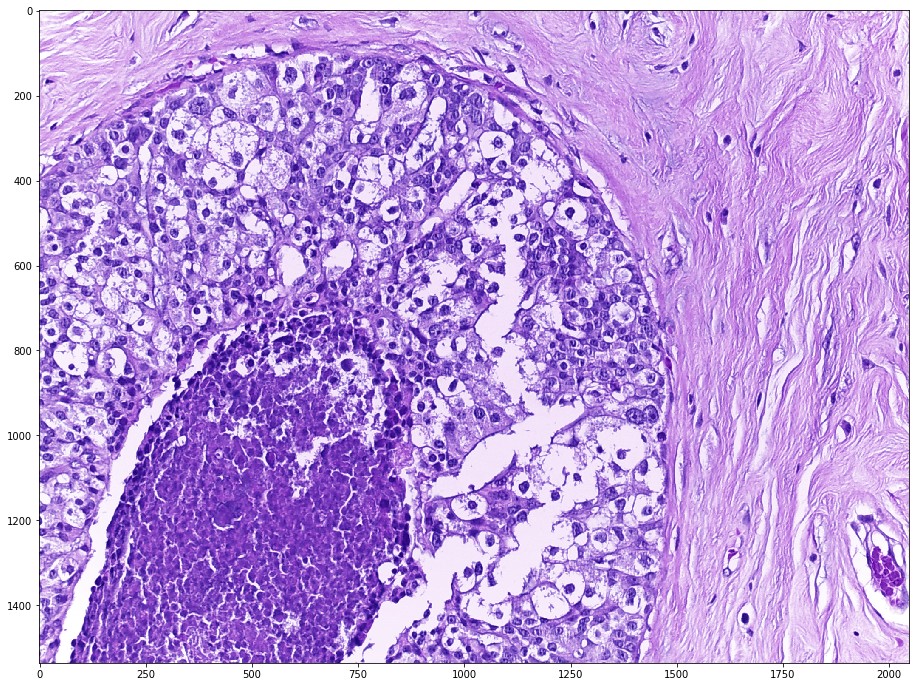

In [41]:
#source
refrence=read_image('./data/i1.png')
n=Normalizer()
n.fit(refrence)
to_transform=read_image('./data/i4.png')
normalized=n.transform(to_transform)
#save image
img = Image.fromarray(normalized, 'RGB')
img.save('normalized.png')
#show image
plt.imshow(normalized, interpolation='nearest')
plt.show()